In [26]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mticker

In [2]:
path = "../data/cleaned_data.csv"
df = pd.read_csv(path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DatePeriod         100000 non-null  object 
 1   AccountID          100000 non-null  int64  
 2   TransactionAmount  100000 non-null  float64
 3   Status             100000 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [4]:
df['DatePeriod'] = pd.to_datetime(df['DatePeriod'])
df.set_index('DatePeriod', inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2023-11-07 10:58:00 to 2023-04-30 04:59:00
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   AccountID          100000 non-null  int64  
 1   TransactionAmount  100000 non-null  float64
 2   Status             100000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ MB


In [6]:
df

,AccountID,TransactionAmount,Status
DatePeriod,,,
2023-11-07 10:58:00,405126,500000.0,sent
2023-11-07 10:56:00,378829,7400.0,sent
2023-11-07 10:56:00,405469,3000.0,sent
2023-11-07 10:56:00,2262,2000.0,sent
2023-11-07 10:54:00,402063,1300.0,sent
...,...,...,...
2023-04-30 05:42:00,364922,583.0,sent
2023-04-30 05:33:00,364922,3525.0,sent
2023-04-30 05:13:00,353700,2000.0,sent


In [7]:
df.AccountID.nunique()

3123

In [8]:
df.columns

Index(['AccountID', 'TransactionAmount', 'Status'], dtype='object')

# user-based insights

### (1.) number of unique AccountID exceeded 50 transactions per month and at what months?
user's transaction counts per month, and those above 50 transactions per month

/tmp/ipykernel_29120/99795331.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=total_users_exceeding_50.index, y=total_users_exceeding_50.values, palette='viridis')


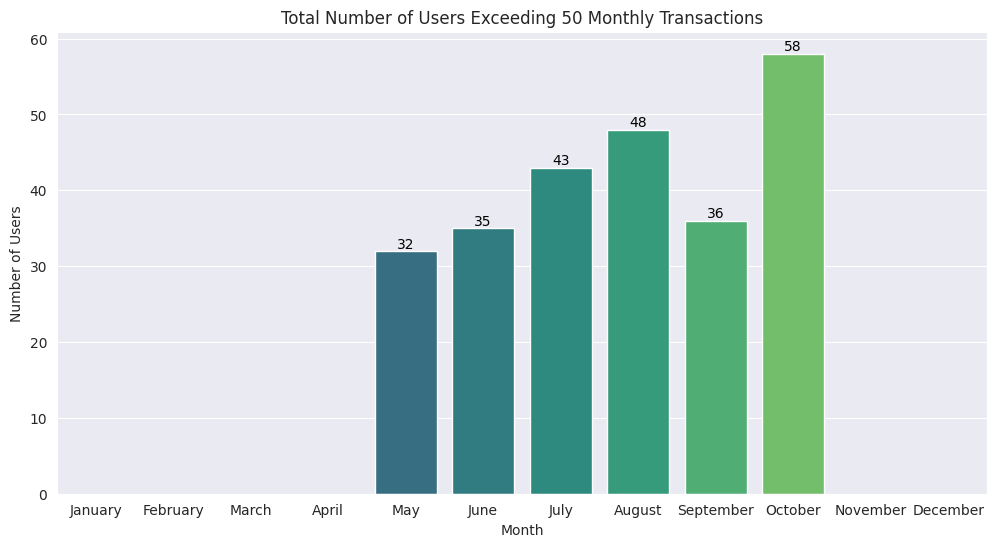

In [16]:
# Group by month and AccountID, and count transactions
monthly_count = df.groupby([df.index.month, 'AccountID'])['TransactionAmount'].count() # for each AccountID per month, count their total amount of transactionamount
exceeded_50per_month = monthly_count[monthly_count > 50] # filter accountID with transactions higher than 50

# Convert to DataFrame and rename columns
exceeded_50per_month_df = pd.DataFrame(exceeded_50per_month.reset_index(name='TransactionCount')) # store in a dataframe and reset/rename the count by the index
exceeded_50per_month_df.rename(columns={'DatePeriod': 'Month'}, inplace=True)

# Map month numbers to names
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# compute the month integer to their precise months by mapping
exceeded_50per_month_df['Month'] = exceeded_50per_month_df['Month'].map(month_mapping)

# Group by month to get total number of users exceeding 50 transactions
total_users_exceeding_50 = exceeded_50per_month_df.groupby('Month')['AccountID'].count().reindex(month_mapping.values())

# Bar plot for TransactionCount by Month
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=total_users_exceeding_50.index, y=total_users_exceeding_50.values, palette='viridis')
plt.title('Total Number of Users Exceeding 50 Monthly Transactions')
plt.xlabel('Month')
plt.ylabel('Number of Users')

# Adding the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

In [11]:
exceeded_50per_month_df

,Month,AccountID,TransactionCount
0,May,524,77
1,May,2520,57
2,May,2719,52
3,May,23621,177
4,May,25887,56
...,...,...,...
247,October,397967,89
248,October,398948,51
249,October,399994,74
250,October,400254,54


In [17]:
exceeded_50per_month_df.AccountID.nunique()

146

In [18]:
# Checking for duplicated AccountIDs
duplicated_users = exceeded_50per_month_df['AccountID'][exceeded_50per_month_df['AccountID'].duplicated()]

duplicated_users.nunique()

58

### (2.) highest transaction accounts for each month

/tmp/ipykernel_29120/2677686778.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Month', y='TransactionAmount', data=highest_transactions, palette='viridis', order=month_mapping.values())


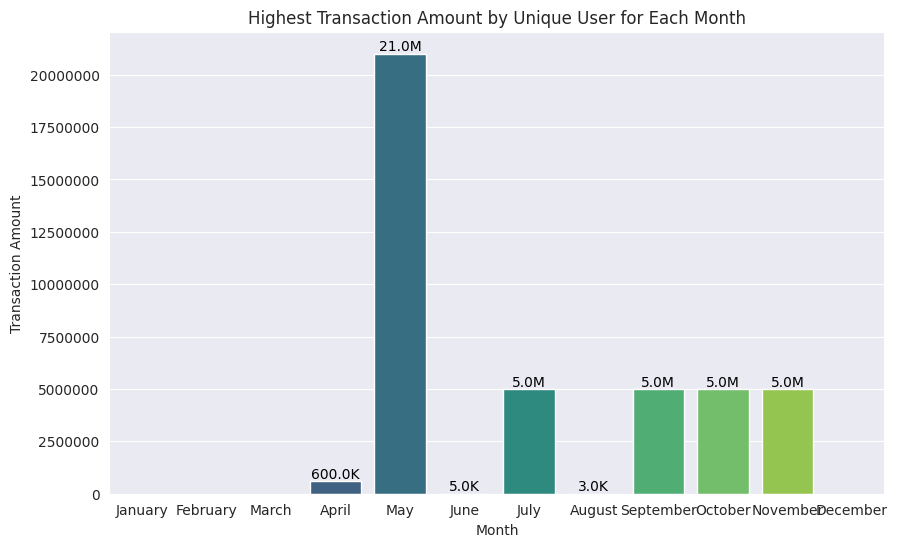

In [48]:
# Group by month and get the index of the highest transaction per month
highest_transaction_per_month_idx = df.groupby([df.index.month])['TransactionAmount'].idxmax()

# Select the rows corresponding to the highest transaction per month
highest_transactions = df.loc[highest_transaction_per_month_idx]

# Map month numbers to names
highest_transactions['Month'] = highest_transactions.index.month.map(month_mapping)

# Remove duplicate months if any (though unlikely in this scenario)
highest_transactions = highest_transactions.drop_duplicates(subset=['Month'])

# Function to format the amounts
def format_amount(value):
    if value >= 1e6:
        return f'{value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.1f}K'
    else:
        return str(value)

# Bar plot for the highest transaction amount by month
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Month', y='TransactionAmount', data=highest_transactions, palette='viridis', order=month_mapping.values())
ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on the y-axis
plt.title('Highest Transaction Amount by Unique User for Each Month')
plt.xlabel('Month')
plt.ylabel('Transaction Amount')

# Adding formatted amounts above the bars
for p in ax.patches:
    formatted_amount = format_amount(p.get_height())
    ax.annotate(formatted_amount, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### (3.) visualization for highest months with more transactions

/tmp/ipykernel_29120/3656609088.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=monthly_total.index, y=monthly_total.values, palette='viridis')


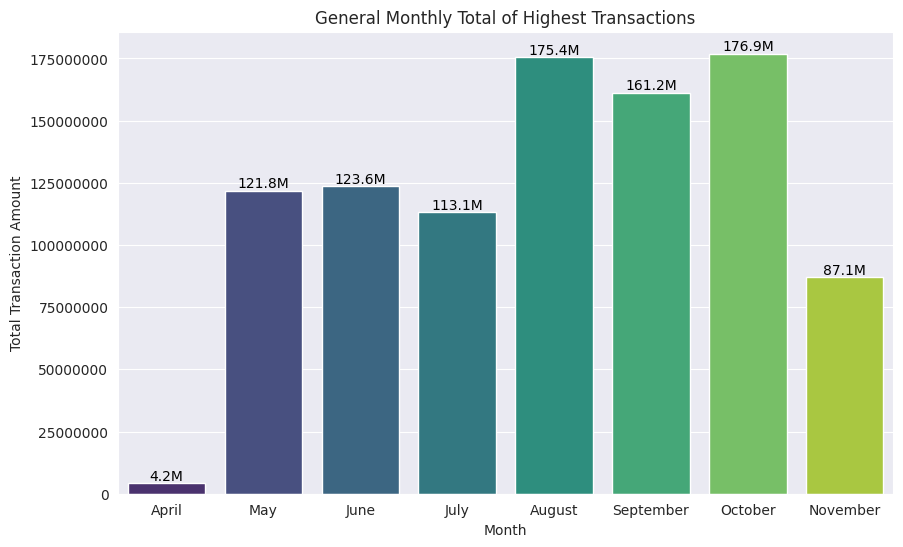

In [49]:
# Group by month and sum the highest transaction amounts per user
monthly_total = df.groupby([df.index.month, 'AccountID'])['TransactionAmount'].max().groupby(level=0).sum()

# Map month numbers to names
monthly_total.index = monthly_total.index.map(month_mapping)

# Function to format the amounts
def format_amount(value):
    if value >= 1e6:
        return f'{value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.1f}K'
    else:
        return str(value)

# Bar plot for total TransactionAmount by month
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=monthly_total.index, y=monthly_total.values, palette='viridis')
ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on the y-axis
plt.title('General Monthly Total of Highest Transactions')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')

# Adding formatted amounts above the bars
for p in ax.patches:
    formatted_amount = format_amount(p.get_height())
    ax.annotate(formatted_amount, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### (4.) users with an average of 30,000 transactions per month?

In [26]:
monthly_avg = df.groupby([df.index.month, 'AccountID'])['TransactionAmount'].mean()
avg_30000_per_month = monthly_avg[monthly_avg > 30000]

monthly_avg_df = pd.DataFrame(monthly_avg.reset_index())
avg_30000_per_month_df = pd.DataFrame(avg_30000_per_month.reset_index())

In [27]:
avg_30000_per_month_df

,DatePeriod,AccountID,TransactionAmount
0,4,451,150000.0
1,4,3415,200000.0
2,4,6000,200000.0
3,4,20362,40000.0
4,4,23621,116800.0
...,...,...,...
1337,11,402709,39350.0
1338,11,404338,31650.0
1339,11,404356,31750.0
1340,11,405126,500000.0


In [28]:
avg_30000_per_month_df.rename(columns={'DatePeriod': 'Month'}, inplace=True)

In [29]:
avg_30000_per_month_df

,Month,AccountID,TransactionAmount
0,4,451,150000.0
1,4,3415,200000.0
2,4,6000,200000.0
3,4,20362,40000.0
4,4,23621,116800.0
...,...,...,...
1337,11,402709,39350.0
1338,11,404338,31650.0
1339,11,404356,31750.0
1340,11,405126,500000.0


### (5.) lowest AccountID with lesser transactions each month

In [30]:
lowest_transaction_per_month = df.groupby([df.index.month])['TransactionAmount'].idxmin()
lowest_transaction_accounts = df.loc[lowest_transaction_per_month]

In [31]:
lowest_transaction_accounts

,AccountID,TransactionAmount,Status
DatePeriod,,,
2023-04-30 19:58:00,359816,500.0,sent
2023-04-30 19:58:00,350454,1000.0,sent
2023-05-31 22:31:00,368779,500.0,sent
2023-06-30 22:07:00,356050,5000.0,sent
2023-06-30 22:07:00,346453,500.0,sent
2023-07-31 23:26:00,82195,500.0,sent
2023-08-31 22:13:00,355222,500.0,sent
2023-09-30 22:05:00,376835,500.0,sent
2023-10-31 21:06:00,392337,500.0,sent


In [32]:
lowest_transaction_accounts.columns

Index(['AccountID', 'TransactionAmount', 'Status'], dtype='object')

In [33]:
lowest_transaction_accounts.index = lowest_transaction_accounts.index.month.map(month_mapping)

In [34]:
lowest_transaction_accounts

,AccountID,TransactionAmount,Status
DatePeriod,,,
April,359816,500.0,sent
April,350454,1000.0,sent
May,368779,500.0,sent
June,356050,5000.0,sent
June,346453,500.0,sent
July,82195,500.0,sent
August,355222,500.0,sent
September,376835,500.0,sent
October,392337,500.0,sent


/tmp/ipykernel_19722/1893578292.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=lowest_transaction_accounts.index, y='TransactionAmount', data=lowest_transaction_accounts, ci=None, palette='viridis')
/tmp/ipykernel_19722/1893578292.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=lowest_transaction_accounts.index, y='TransactionAmount', data=lowest_transaction_accounts, ci=None, palette='viridis')


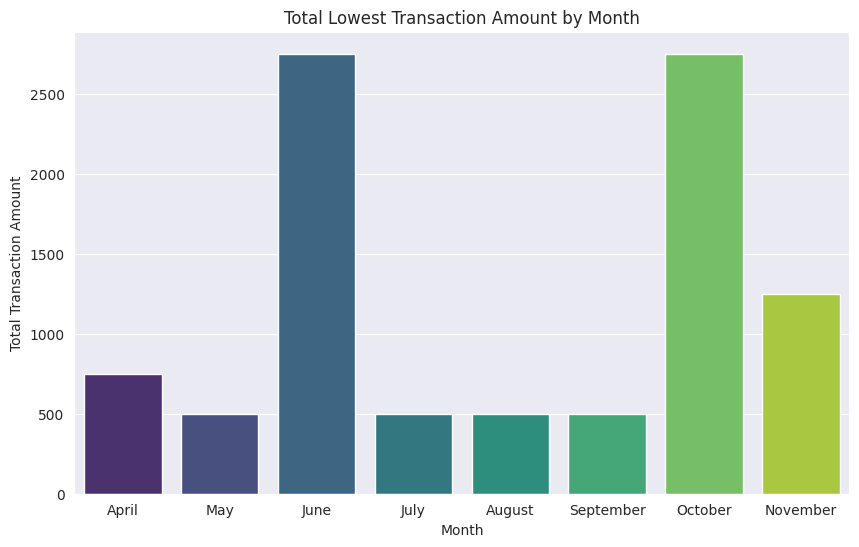

In [35]:
# Bar plot for total TransactionAmount by month
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=lowest_transaction_accounts.index, y='TransactionAmount', data=lowest_transaction_accounts, ci=None, palette='viridis')
ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on the y-axis
plt.title('Total Lowest Transaction Amount by Month')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')
plt.show()

### (6.) day-of-week AccountID (users) do the highest and lowest transactions so far?

In [36]:
df['DayOfWeek'] = df.index.day_name()
day_of_week_highest_transactions = df.groupby(['AccountID', 'DayOfWeek'])['TransactionAmount'].sum().idxmax()
day_of_week_lowest_transactions = df.groupby(['AccountID', 'DayOfWeek'])['TransactionAmount'].sum().idxmin()


In [37]:
day_of_week_highest_transactions

(193206, 'Wednesday')

In [38]:
day_of_week_lowest_transactions

(8883, 'Friday')

In [39]:
consistent_day_highest = day_of_week_highest_transactions[1]
consistent_day_lowest = day_of_week_lowest_transactions[1]

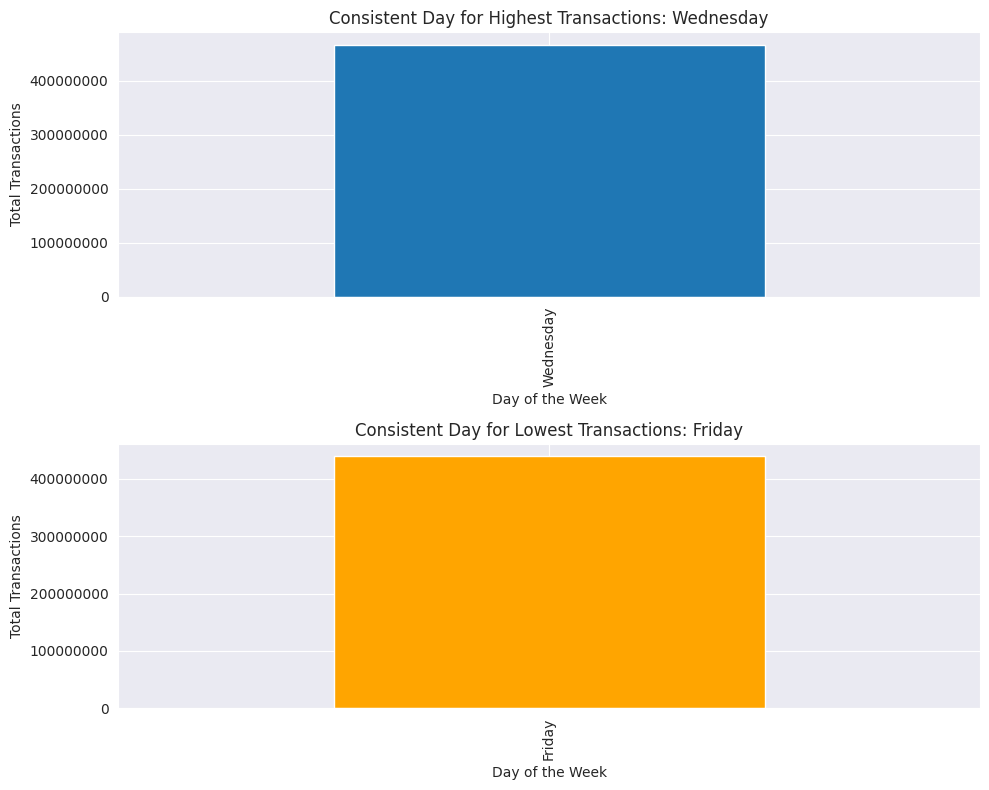

In [40]:
# Plot a visualization
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot for highest transactions
df[df['DayOfWeek'] == consistent_day_highest].groupby('DayOfWeek')['TransactionAmount'].sum().plot(kind='bar', ax=axes[0])
axes[0].set_title(f'Consistent Day for Highest Transactions: {consistent_day_highest}')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Total Transactions')
axes[0].get_yaxis().get_major_formatter().set_scientific(False)

# Plot for lowest transactions
df[df['DayOfWeek'] == consistent_day_lowest].groupby('DayOfWeek')['TransactionAmount'].sum().plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title(f'Consistent Day for Lowest Transactions: {consistent_day_lowest}')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Total Transactions')
axes[1].get_yaxis().get_major_formatter().set_scientific(False)

plt.tight_layout()
plt.show()

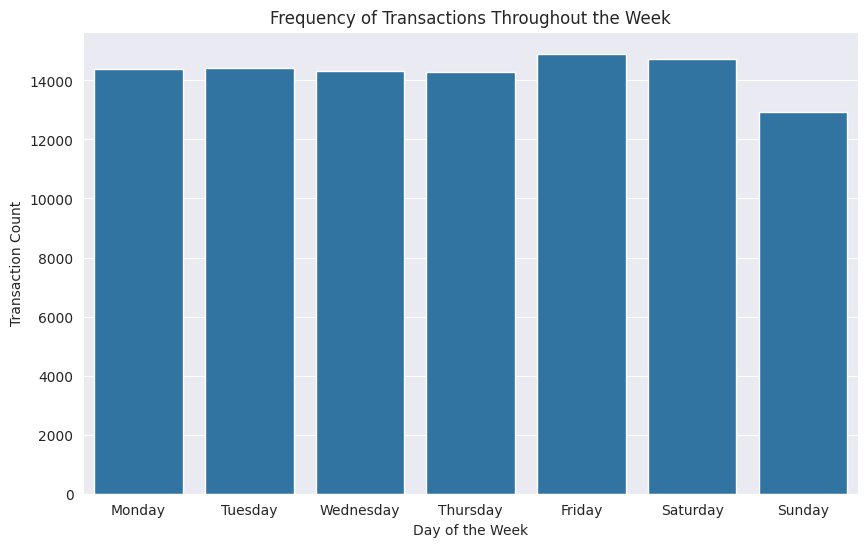

In [41]:
# Plot a visualization for the frequency of transactions throughout the week
plt.figure(figsize=(10, 6))
sns.countplot(x='DayOfWeek', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Frequency of Transactions Throughout the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Transaction Count')
plt.show()

### (7.) time of day AccountID do the most transactions?

In [42]:
df['HourOfDay'] = df.index.hour
hour_of_day_most_transactions = df.groupby(['AccountID', 'HourOfDay'])['TransactionAmount'].sum().idxmax()

In [43]:
hour_of_day_most_transactions

(348964, 5)

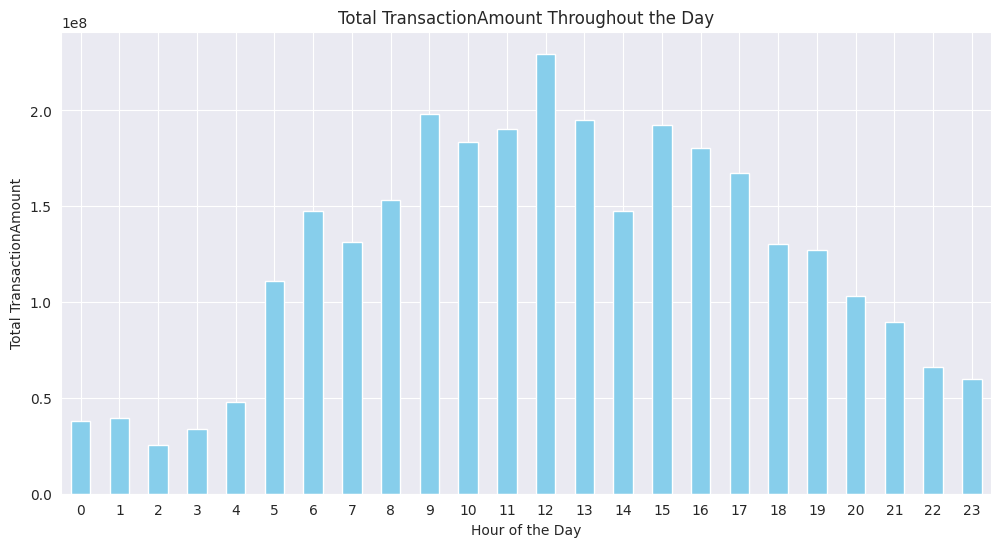

In [44]:
# visualization plot for total TransactionAmount throughout the day
plt.figure(figsize=(12, 6))
df.groupby('HourOfDay')['TransactionAmount'].sum().plot(kind='bar', color='skyblue')
plt.title('Total TransactionAmount Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total TransactionAmount')
plt.xticks(rotation=0)  # for readability
plt.show()

# other miscelleneous insights

### 8. transaction volume over time

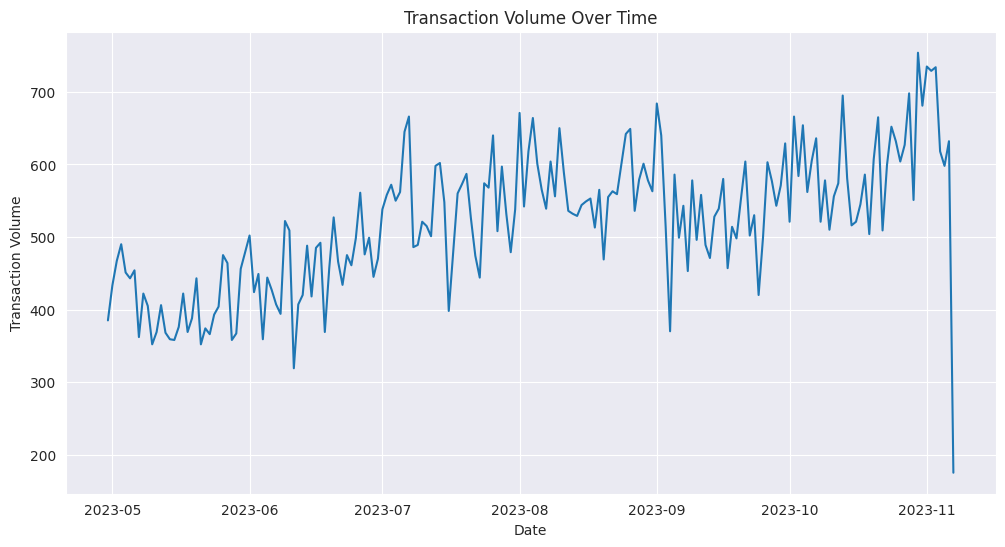

In [45]:
transaction_volume_over_time = df.resample('D').size()

plt.figure(figsize=(12, 6))
plt.plot(transaction_volume_over_time)
plt.title('Transaction Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Volume')
plt.show()

### 9. transaction status distribution

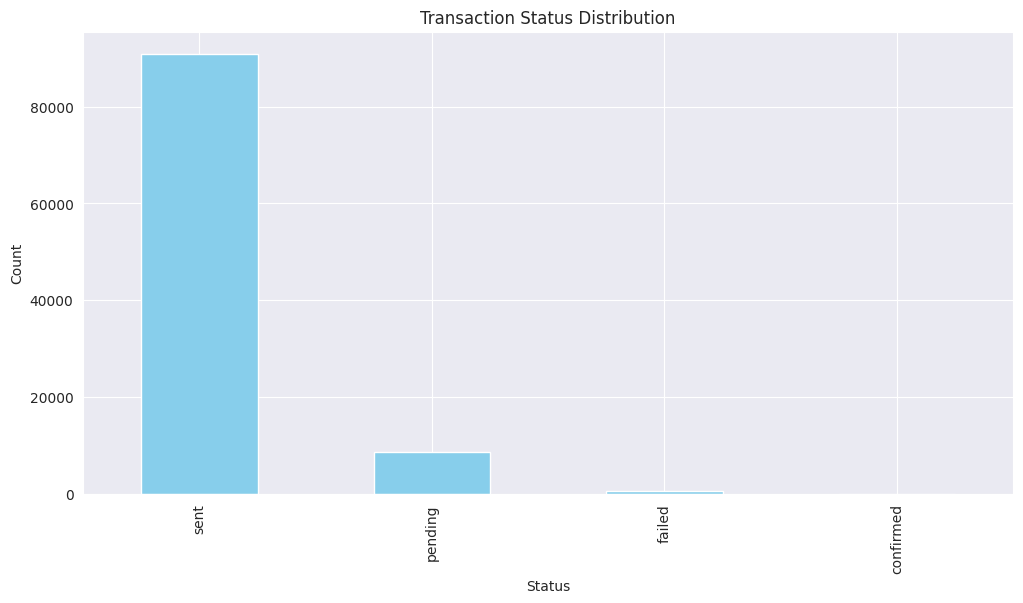

In [46]:
plt.figure(figsize=(12, 6))
status_distribution = df['Status'].value_counts()
status_distribution.plot(kind='bar', color='skyblue')
plt.title('Transaction Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()


### 10. top 10 users by transaction count

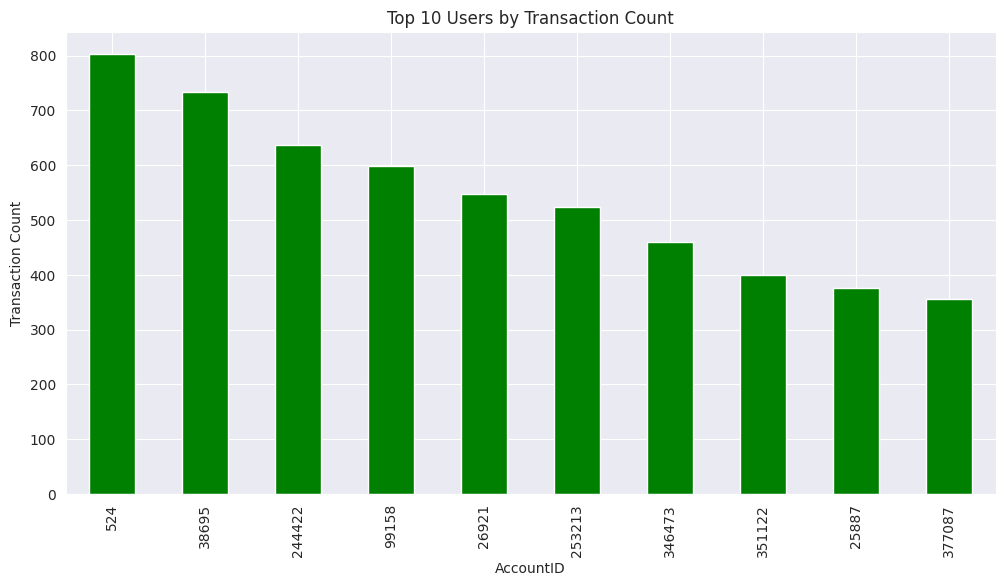

In [47]:
plt.figure(figsize=(12, 6))
top_users_by_count = df['AccountID'].value_counts().head(10)
top_users_by_count.plot(kind='bar', color='green')
plt.title('Top 10 Users by Transaction Count')
plt.xlabel('AccountID')
plt.ylabel('Transaction Count')
plt.show()

### 11. top 10 users by transaction amount

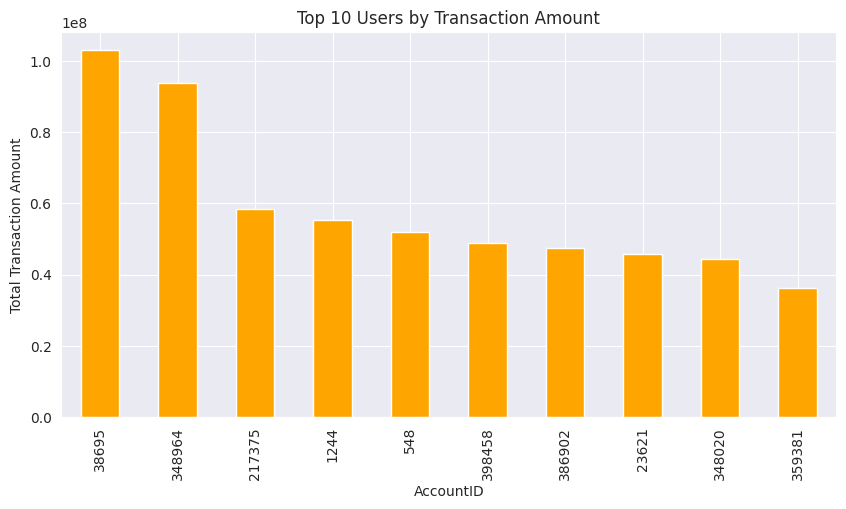

In [48]:
plt.figure(figsize=(10, 5))
top_users_by_amount = df.groupby('AccountID')['TransactionAmount'].sum().nlargest(10)
top_users_by_amount.plot(kind='bar', color='orange')
plt.title('Top 10 Users by Transaction Amount')
plt.xlabel('AccountID')
plt.ylabel('Total Transaction Amount')
plt.show()


### 12. transaction amount over time

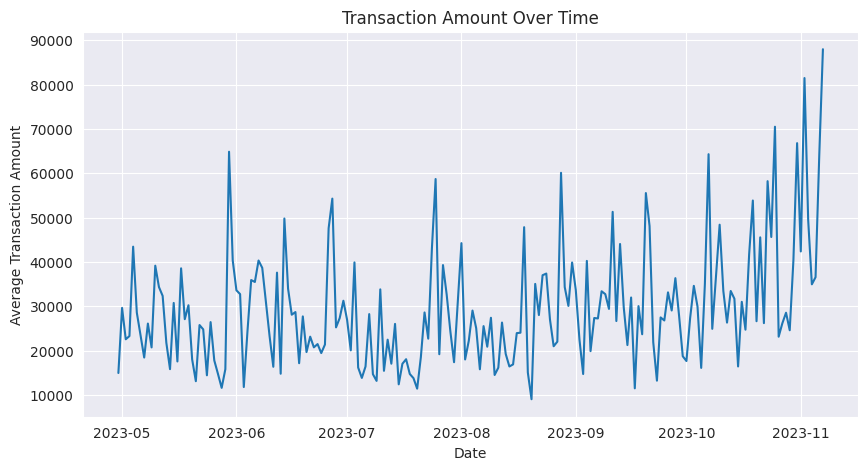

In [49]:
plt.figure(figsize=(10, 5))
transaction_amount_over_time = df.resample('D')['TransactionAmount'].mean()
plt.plot(transaction_amount_over_time)
plt.title('Transaction Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Average Transaction Amount')
plt.show()


### 13. busiest days and hours

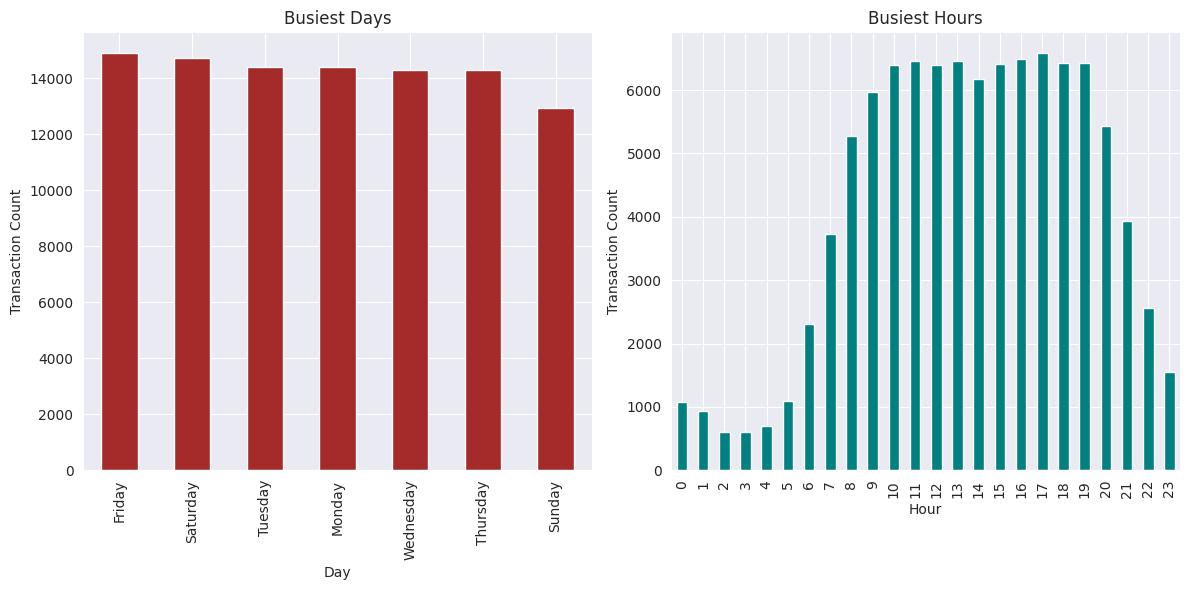

In [50]:
busiest_days = df.index.day_name()
busiest_hours = df.index.hour

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
busiest_days.value_counts().plot(kind='bar', color='brown')
plt.title('Busiest Days')
plt.xlabel('Day')
plt.ylabel('Transaction Count')

plt.subplot(1, 2, 2)
busiest_hours.value_counts().sort_index().plot(kind='bar', color='teal')
plt.title('Busiest Hours')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')

plt.tight_layout()
plt.show()

### 14. transaction status over time

<Figure size 1200x600 with 0 Axes>

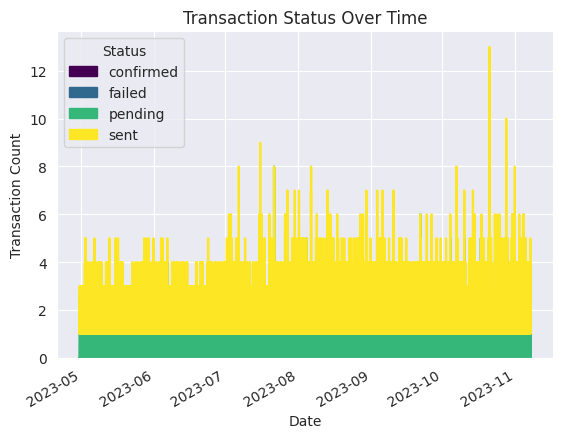

In [51]:
plt.figure(figsize=(12, 6))
status_over_time = df.groupby([df.index, 'Status']).size().unstack()
status_over_time.plot.area(stacked=True, colormap='viridis')
plt.title('Transaction Status Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.show()

### 15. user engagement over time

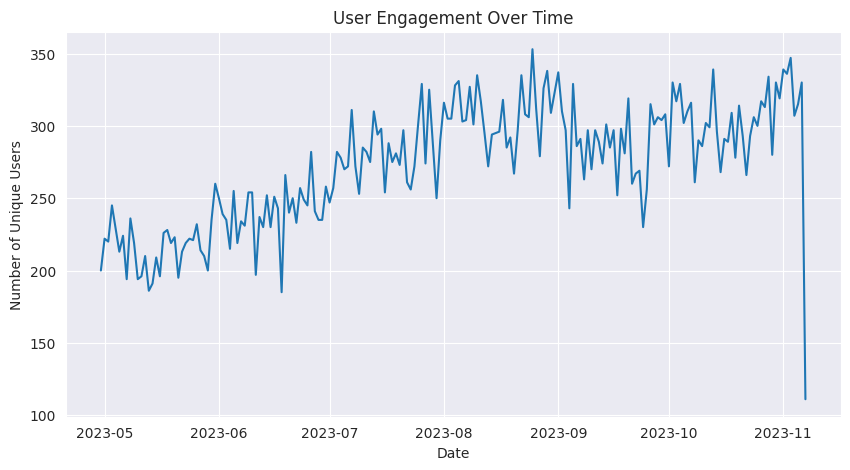

In [52]:
plt.figure(figsize=(10, 5))
user_engagement_over_time = df.resample('D')['AccountID'].nunique()
plt.plot(user_engagement_over_time)
plt.title('User Engagement Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Unique Users')
plt.show()